# Chapter 8 Lab 2

## Goal
We are going to learn how to plot the ROC and the respective AUC curves to evaluate a Naive Bayes model's performance.

We will again consider the task of predicting players’ SkillLevel, which takes integer value between 0 and 3, with 0 being novice level and 3 expert.

For illustrative purposes, consider the Naive Bayes model from Chapter 7, lab 3 (note that you can use any other model you have trained so far for this purpose).

## Brief Refresher

AUC stands for Area Under the Curve. The curve in question visualizes the relationship between a model's sensitivity, or True Positive rate and 1-specificity or False positive rate.

AUC ranges between 0 and 1 with 1 being good and 0 being bad.

## Preparation

Load the required packages below.

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score,  auc, RocCurveDisplay 
from sklearn.naive_bayes import GaussianNB
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sys
from io import StringIO

import warnings
warnings.filterwarnings('ignore')

## Step 1: Data Pre-processing and Model Building

We've done these steps enough to condense them together in order to speed the process of getting to metric evaluation.

In [3]:
dota_df1 = pd.read_csv('DoTalicious_cleaned1000players.csv')
dota_df1.drop(['PlayerID'], axis=1, inplace=True)

dota_df1 = dota_df1.rename(columns=lambda x: x.strip())

dota_df1['TotalTime'] = pd.to_numeric(dota_df1['TotalTime'], errors='coerce')

dota_df1.loc[dota_df1['SkillLevel'] ==' SkillLevelNull', 'SkillLevel'] = '1'

dota_df1['SkillLevel'] = pd.Series(dota_df1['SkillLevel'].astype('category'))

dota_df1['SkillLevel'] = dota_df1['SkillLevel'].cat.rename_categories({'0':'N', '1':'B', '2':'I', '3':'A'})

dota_df1.drop([517], inplace=True)

dota_df1.describe()

,GamesPlayed,GamesWon,GamesLeft,Ditches,Points,Kills,KillsPerMin,Deaths,Assists,CreepsKilled,CreepsDenied,NeutralsKilled,TowersDestroyed,RaxsDestroyed,TotalTime
count,867.000000,867.000000,867.000000,867.000000,867.000000,867.000000,867.000000,867.000000,867.000000,867.000000,867.000000,867.000000,867.000000,867.000000,8.670000e+02
mean,92.343714,50.369089,1.650519,0.711649,1014.840856,608.660900,0.131799,545.094579,951.763552,7636.831603,677.627451,1259.800461,70.786621,29.740484,2.283400e+05
std,205.574415,115.795471,3.239320,1.808982,119.954984,1502.754591,0.065829,1204.140278,2230.809200,19801.024410,2029.775852,2969.501221,175.869846,74.661056,4.751062e+05
min,1.000000,0.000000,0.000000,0.000000,626.837000,0.000000,0.000000,0.000000,0.000000,9.000000,0.000000,0.000000,0.000000,0.000000,1.349000e+03
25%,3.000000,1.000000,0.000000,0.000000,961.886000,11.000000,0.090000,17.500000,18.000000,160.500000,12.000000,16.000000,1.000000,0.000000,6.270000e+03
50%,15.000000,7.000000,0.000000,0.000000,996.646000,74.000000,0.130000,93.000000,125.000000,983.000000,76.000000,146.000000,7.000000,3.000000,3.516000e+04
75%,90.000000,47.500000,2.000000,1.000000,1046.975000,514.500000,0.170000,554.000000,865.000000,6732.000000,541.500000,1130.500000,62.000000,26.000000,2.234100e+05
max,3156.000000,1764.000000,40.000000,18.000000,2010.240000,23742.000000,0.420000,16988.000000,34390.000000,372360.000000,43910.000000,42900.000000,2601.000000,1141.000000,4.294920e+06


Next, we'll split the data first into predictors and target and then into training and test

In [4]:
y = dota_df1['SkillLevel']
X = dota_df1.drop(['SkillLevel'], axis=1, inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=101)

Laslty, since we don't need to standardize for the NaiveBayes, we'll run our model.

We'll need to call 'predict_proba' on our model for 'roc_auc_score'. 

In [5]:
#define model
gnb = GaussianNB()
gnb.fit(X_train, y_train)
gnb_pred = gnb.predict(X_test)
gnb_pred_prob = gnb.predict_proba(X_test)

## Step 2: Compute AUC


Python also offers an 'auc_score', but it does not support multi-class scenarios. As a result, we use 'roc_auc_score'.

In [6]:
roc_auc_score(y_test, gnb_pred_prob, multi_class='ovr' )

0.9240146761091477

To mimic R's method, we need to bin our target.

In [31]:
from sklearn.preprocessing import LabelBinarizer

In [32]:
label_binarizer = LabelBinarizer().fit(y_train)
y_test_lb = label_binarizer.transform(y_test)

Compare before and after shapes - we've added 4 "columns", 1 for each SkillLevel.

In [38]:
print("y_test shape: ", y_test.shape)
print("y_test_lb shape: ", y_test_lb.shape)

y_test shape:  (217,)
y_test_lb shape:  (217, 4)


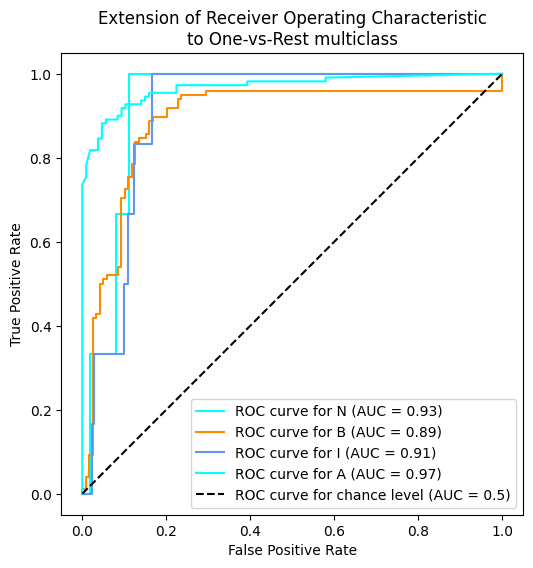

In [35]:
from itertools import cycle

n_classes = len(np.unique(y_test))
target_names = ['N', 'B', 'I', 'A']

fig, ax = plt.subplots(figsize=(6, 6))

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(
        y_test_lb[:, class_id],
        gnb_pred_prob[:, class_id],
        name=f"ROC curve for {target_names[class_id]}",
        color=color,
        ax=ax,
    )

plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass")
plt.legend()
plt.show()

Do you notice the larger "choppiness" or steps present in Intermediate and Advanced curves? That's because there is less data available for I and A skill levels.

Using 'ovr' - One Versus Rest - Naive Bayes performs well.

## Conclusion

In this lab, we showed you how to draw the ROC curve as well as computing AUC values for a Naive Bayes model, using the ROCR package. You can replicate that for other models that you learned through Chapter 7 labs.

In Python, however, depending on the model you choose to use, you may need to call a different function, i.e, 'decision_function' for LinearSVC.